## Overstory Geospatial Data Engineer Take-Home Exercise

#### Christian Schroeder (cschroeder1338@gmail.com)


#### Steps Taken

For this task, I first inspected the individual raster files and their distribution of values. I then used GDAL and rioxarray to merge the DSM files together, and create a CHM. I found the first run to not be so accurate. So, I adjusted one of the DSMs to be more inline with the other two, then re-ran the process with the adjusted DSM.

Resources:
- https://gis.stackexchange.com/questions/324602/averaging-overlapping-rasters-with-gdal
- https://github.com/corteva/rioxarray/discussions/313

In [1]:
import rioxarray as rxr
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, Markdown

#files
dem_fname = "dem_3_copernicus_clipped.tif"
dsm_fnames = ["dsm_3d.tif","dsm_3e.tif","dsm_3g.tif"]

## Functions

In [2]:
def mosaicByAvg(files, output_fname, noDataValue):
    # create VRT
    vrt_fname = output_fname[:-4] + ".vrt"
    options = gdal.BuildVRTOptions(srcNodata=noDataValue)
    gdal.BuildVRT(destName=vrt_fname, srcDSOrSrcDSTab=files, options=options)
    
    # add PixelFunctionCode to get pixel averages in overlaps
    header = """  <VRTRasterBand dataType="Float32" band="1" subClass="VRTDerivedRasterBand">"""
    contents = """
    <PixelFunctionType>average</PixelFunctionType>
    <PixelFunctionLanguage>Python</PixelFunctionLanguage>
    <PixelFunctionCode><![CDATA[
import numpy as np
def average(in_ar, out_ar, xoff, yoff, xsize, ysize, raster_xsize,raster_ysize, buf_radius, gt, **kwargs):
    x = np.ma.masked_less(in_ar, 0)
    np.mean(x, axis = 0, out = out_ar, dtype = 'float64')
    mask = np.all(x.mask,axis = 0)
    out_ar[mask]={0}
]]>
    </PixelFunctionCode>
"""
    lines = open(vrt_fname, 'r').readlines()
    lines[3] = header
    lines.insert(4, contents.format(str(noDataValue)))
    open(vrt_fname, 'w').write("".join(lines))
    
    # Translate the input files to single .tif
    gdal.SetConfigOption('GDAL_VRT_ENABLE_PYTHON', 'YES')
    gdal.Translate(destName=output_fname, srcDS=vrt_fname)
    gdal.SetConfigOption('GDAL_VRT_ENABLE_PYTHON', None)
    
    # check
    if os.path.exists(output_fname):
        print(f"{output_fname} created.")
    else:
        print(f"Failed to create {output_fname}.") 
    
def inspectRXR(_rxr):
    print(f"CRS: {_rxr.rio.crs}")
    print(f"Bounds: {_rxr.rio.bounds()}")
    print(f"Resolution: {_rxr.rio.resolution()}")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    _rxr.plot(ax=ax1)
    _rxr.plot.hist(bins=200, ax=ax2)
    plt.show()
    
def buildCHM(dem, dsm, norm=True):
    # get canopy height and raise all negative values to 0
    chm = dsm - dem
    if norm:
        chm = chm.where((chm > 0) | chm.isnull(), 0)
    inspectRXR(chm)
    return chm

# Process

## Inspect Data

CRS: EPSG:4326
Bounds: (-111.35930555531966, 45.269861110944994, -111.08736111116772, 45.540972222269154)
Resolution: (0.00027777777747899546, -0.0002777777779960662)


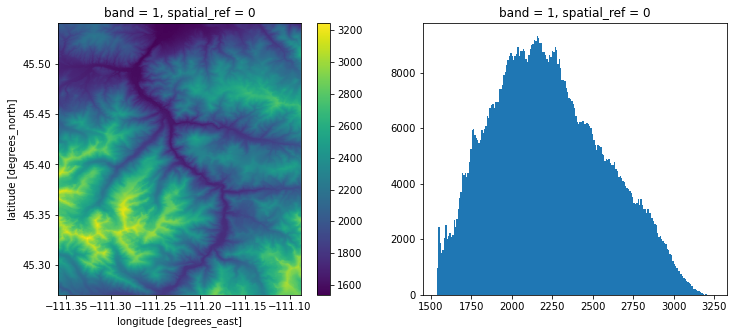

CRS: EPSG:4326
Bounds: (-111.35930555531966, 45.269861110944994, -111.08736111116772, 45.540972222269154)
Resolution: (0.00027777777747899546, -0.0002777777779960662)


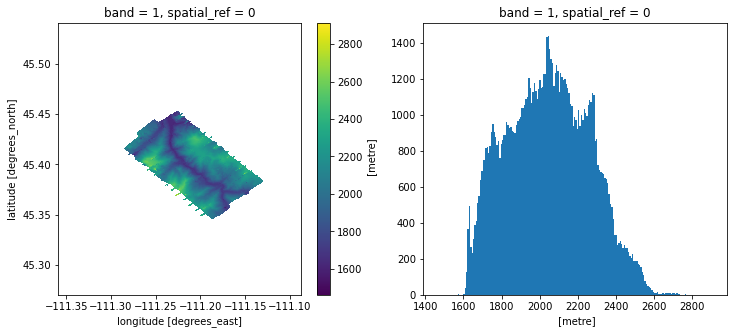

CRS: EPSG:4326
Bounds: (-111.35930555531966, 45.269861110944994, -111.08736111116772, 45.540972222269154)
Resolution: (0.00027777777747899546, -0.0002777777779960662)


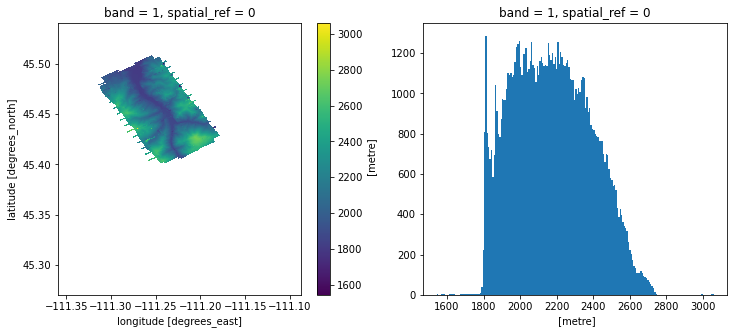

CRS: EPSG:4326
Bounds: (-111.35930555531966, 45.269861110944994, -111.08736111116772, 45.540972222269154)
Resolution: (0.00027777777747899546, -0.0002777777779960662)


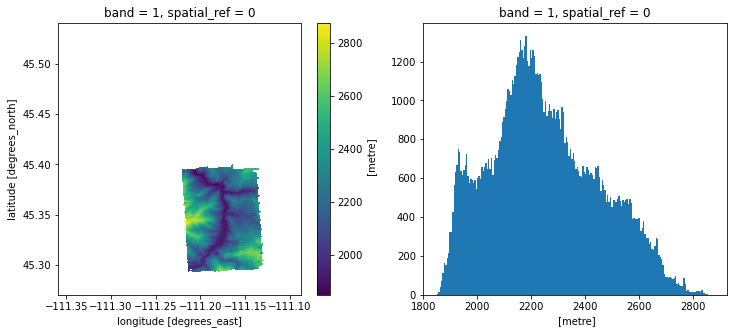

In [3]:
# dem
xr_dem = rxr.open_rasterio(dem_fname, masked=True).squeeze()
xr_dsmD = rxr.open_rasterio(dsm_fnames[0], masked=True).squeeze()
xr_dsmE = rxr.open_rasterio(dsm_fnames[1], masked=True).squeeze()
xr_dsmG = rxr.open_rasterio(dsm_fnames[2], masked=True).squeeze()

# clip dem to the bounds of the DSMs
db, eb, gb = xr_dsmD.rio.bounds(), xr_dsmE.rio.bounds(), xr_dsmG.rio.bounds()
minx = [db[0], eb[0], gb[0]]
miny = [db[1], eb[1], gb[1]]
maxx = [db[2], eb[2], gb[2]]
maxy = [db[3], eb[3], gb[3]]
xr_dem = xr_dem.rio.clip_box(minx=min(minx), miny=min(miny), maxx=max(maxx), maxy=max(maxy))

# reproject to match the dem (thought about using interp_like but felt this would cover all the bases, just in case)
xr_dsmD_rep = xr_dsmD.rio.reproject_match(xr_dem)
xr_dsmE_rep = xr_dsmE.rio.reproject_match(xr_dem)
xr_dsmG_rep = xr_dsmG.rio.reproject_match(xr_dem)

# inspect
inspectRXR(xr_dem)
inspectRXR(xr_dsmD_rep)
inspectRXR(xr_dsmE_rep)
inspectRXR(xr_dsmG_rep)

The distribution of height values for dsmD appears slightly shifted down compared to that of dsmE and dsmG. I feel like the amount of pixels that fall below 1800 may be a problem, especially if they are the ones that overlap.

## Build Single DSM

To deal with the overlaps when merging, I want to get the average pixel value for where they overlap to mitigate strong differences. I couldn't find a straight forward method to do this with rioxarray, so I'm trying with a VRT and GDAL. The mosaicByAvg function creates a VRT, adds the python function to get the average value to the VRT, and then runs gdal.Translate() to create a single DSM file.

In [4]:
output_fname = "dsm.tif"
mosaicByAvg(dsm_fnames, output_fname, -32767)

dsm.tif created.


Reproject the new DSM to match the DEM. I tried interp_like() but felt reproject_match was the safest because it pretty much covers all the bases.

CRS: EPSG:4326
Bounds: (-111.35930555531966, 45.269861110944994, -111.08736111116772, 45.540972222269154)
Resolution: (0.00027777777747899546, -0.0002777777779960662)


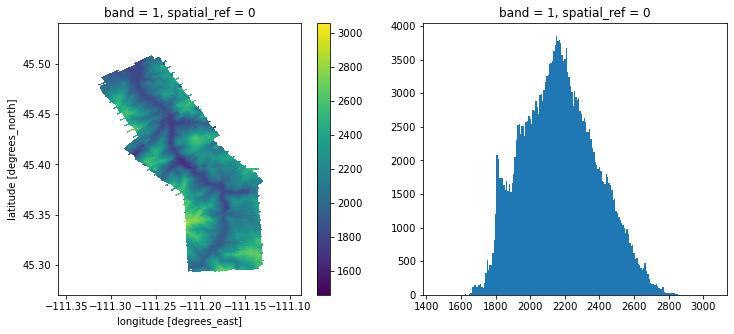

CRS: EPSG:4326
Bounds: (-111.35930555531966, 45.269861110944994, -111.08736111116772, 45.540972222269154)
Resolution: (0.00027777777747899546, -0.0002777777779960662)


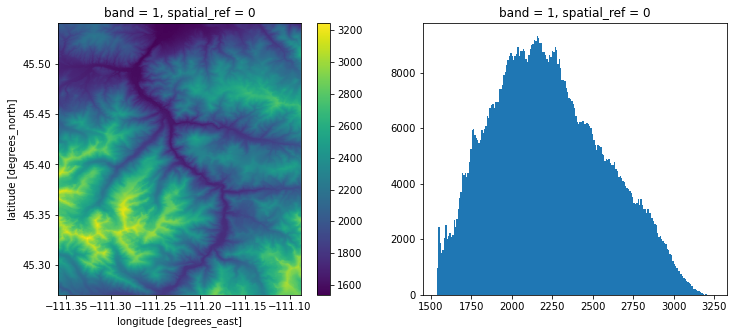

In [5]:
# import dem and dsm
xr_dem = rxr.open_rasterio(dem_fname, masked=True).squeeze()
xr_dsm = rxr.open_rasterio(output_fname, masked=True).squeeze()

# clip dem to dsm bounds
minx, miny, maxx, maxy = xr_dsm.rio.bounds()
xr_dem = xr_dem.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

# reproject DSM to DEM for memory saving
xr_dsm_rep = xr_dsm.rio.reproject_match(xr_dem)

# inspect
inspectRXR(xr_dsm_rep)
inspectRXR(xr_dem)

The merged DSM looks ehh. There are visible borders on the overlapping areas, but the distribution of values doesn't look that bad.

## Build CHM

The buildCHM function is pretty simple. Subtract the DEM from the DSM, and ceiling any negative values up to 0.

CRS: EPSG:4326
Bounds: (-111.35930555531966, 45.269861110944994, -111.08736111116772, 45.540972222269154)
Resolution: (0.00027777777747899546, -0.0002777777779960662)


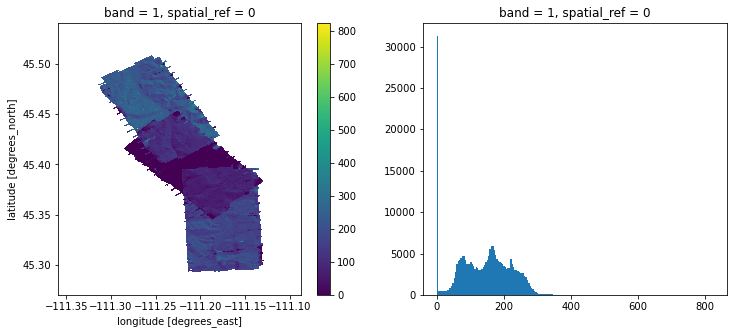

In [6]:
xr_chm = buildCHM(xr_dem, xr_dsm_rep)

The large amount of 0 values is concerning, and the map shows a clear difference between the different DSMs. I'm thinking that dsmD may need to be shifted upwards to better match the elevations of the other DSMs?

### Check differences in overlapping regions

I want to check the distribution of differences in the overlapping regions

CRS: EPSG:4326
Bounds: (-111.35930555531966, 45.269861110944994, -111.08736111116772, 45.540972222269154)
Resolution: (0.00027777777747899546, -0.0002777777779960662)


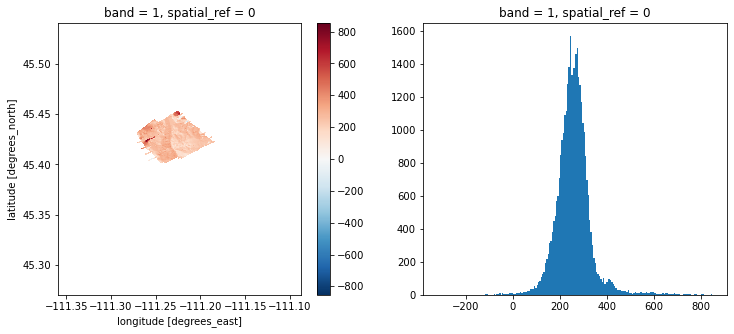

CRS: EPSG:4326
Bounds: (-111.35930555531966, 45.269861110944994, -111.08736111116772, 45.540972222269154)
Resolution: (0.00027777777747899546, -0.0002777777779960662)


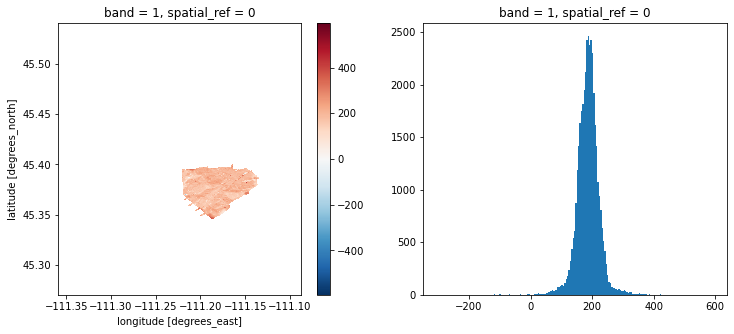

In [7]:
EsubD = xr_dsmE_rep - xr_dsmD_rep
GsubD = xr_dsmG_rep - xr_dsmD_rep
inspectRXR(EsubD)
inspectRXR(GsubD)

Because these are overlapping regions, and the 'ideal' difference would be 0, I would want to see a normal-ish distribution around 0. But, it looks like dsmD is falling ~190 to ~230 meters behind in these overlapping areas.

I think shifting the dsmD by a value within that range may mitigate the negative CHM values a little bit.

CRS: EPSG:4326
Bounds: (-111.35930555531966, 45.269861110944994, -111.08736111116772, 45.540972222269154)
Resolution: (0.00027777777747899546, -0.0002777777779960662)


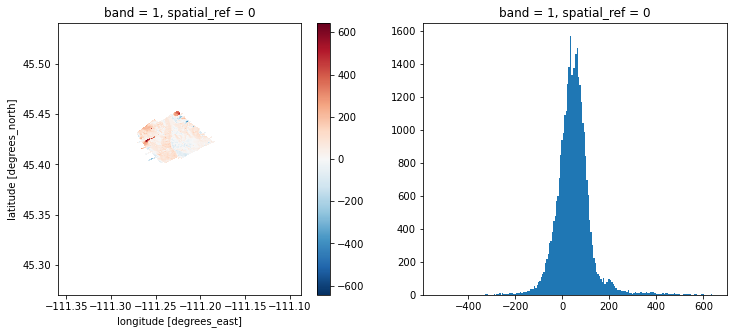

CRS: EPSG:4326
Bounds: (-111.35930555531966, 45.269861110944994, -111.08736111116772, 45.540972222269154)
Resolution: (0.00027777777747899546, -0.0002777777779960662)


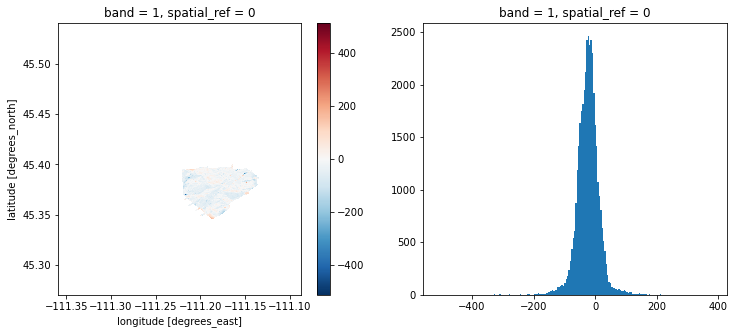

In [8]:
EsubD = xr_dsmE_rep - (xr_dsmD_rep + 210)
GsubD = xr_dsmG_rep - (xr_dsmD_rep + 210)
inspectRXR(EsubD)
inspectRXR(GsubD)

Shifting dsmD by 210 meters did shift those distributions closer to 0, so I am hoping that will reduce those negatives by a little.

### Rebuild the CHM with adjusted dsmD raster

To implement the adjustment, I'm just going to export an updated version of dsmD and run that back through the same process as before.

In [9]:
# make adjustment to full data
xr_dsmD_plus = (xr_dsmD + 210)

# copy over xarray attributes
xr_dsmD_plus.attrs = xr_dsmD.attrs
xr_dsmD_plus.rio.update_attrs(xr_dsmD.attrs, inplace=True)
xr_dsmD_plus.rio.write_nodata(xr_dsmD.rio.encoded_nodata, encoded=True, inplace=True)

# export updated data to raster to go back into mosaicByAvg
xr_dsmD_plus.rio.to_raster('dsm_3dplus.tif')

In [10]:
# re-run merge but with updated raster
mosaicByAvg(['dsm_3dplus.tif', 'dsm_3e.tif', 'dsm_3g.tif'], "dsmplus.tif", -32767)

dsmplus.tif created.


CRS: EPSG:4326
Bounds: (-111.35930555531966, 45.269861110944994, -111.08736111116772, 45.540972222269154)
Resolution: (0.00027777777747899546, -0.0002777777779960662)


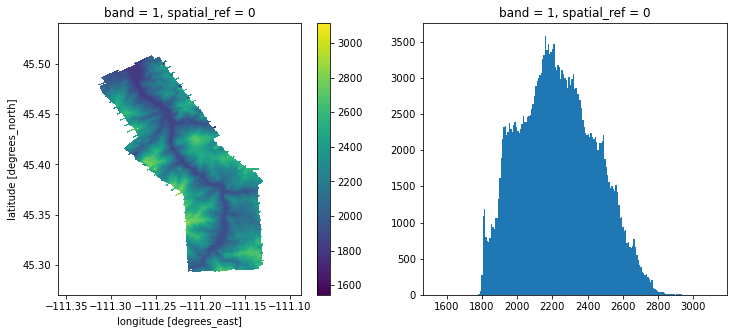

In [11]:
# import updated DSM
xr_dsm_adj = rxr.open_rasterio("dsmplus.tif", masked=True).squeeze()

# reproject DSM to DEM for memory saving
xr_dsm_adj_rep = xr_dsm_adj.rio.reproject_match(xr_dem)

# inspect
inspectRXR(xr_dsm_adj_rep)

It looks like adjusting dsmD smoothed out a few of the areas along the borders of the overlap. The rasters now appear to be a little more cohesive.

CRS: EPSG:4326
Bounds: (-111.35930555531966, 45.269861110944994, -111.08736111116772, 45.540972222269154)
Resolution: (0.00027777777747899546, -0.0002777777779960662)


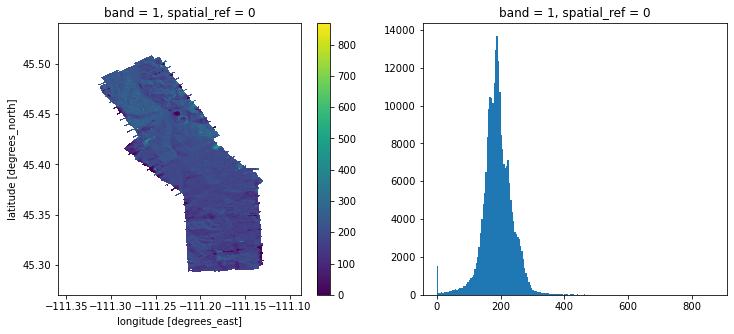

In [12]:
# build new CHM
adj_chm = buildCHM(xr_dem, xr_dsm_adj_rep)

Now the CHM looks like it is more accurate, I believe. The separate DSMs mesh together more smoothly, and in turn create a better CHM. There are still some negative values that got pushed to 0, but not nearly as many.

## Export

I think this CHM is pretty good so far. If I had more time I would probably want to check the elevation values for dsmD against another dataset, to be sure the adjustment was warranted. I also would have wanted to try upsampling the DEM rather than downsampling the DSMs, but am limited by my laptops abilities.

In [13]:
# copy over xarray attributes
adj_chm.attrs = xr_dsm_adj_rep.attrs
adj_chm.rio.update_attrs(xr_dsm_adj_rep.attrs, inplace=True)
adj_chm.rio.write_nodata(xr_dsm_adj_rep.rio.encoded_nodata, encoded=True, inplace=True)

# export adjusted CHM to raster
adj_chm.rio.to_raster('CHM_adjusted.tif')

In [14]:
xr_chm_adj = rxr.open_rasterio("CHM_adjusted.tif", masked=True).squeeze()

CRS: EPSG:4326
Bounds: (-111.35930555531966, 45.269861110944994, -111.08736111116772, 45.540972222269154)
Resolution: (0.00027777777747899546, -0.0002777777779960662)


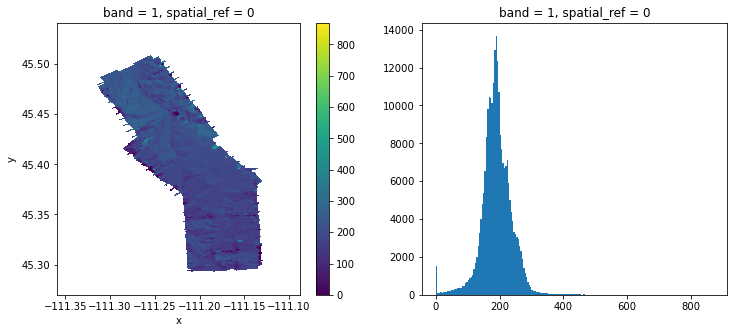

In [16]:
inspectRXR(xr_chm_adj)